In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools as it
from itertools import cycle 
import os.path as op
import timeit 
import json
from matplotlib import animation
import matplotlib.font_manager as font_manager

# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

Import MDAnalysis

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import MDAnalysis.analysis.distances as maa_dist

In [4]:
#Units of Angstroms 
dmax = 4.0 

In [5]:
## Define a function that does this, Courtesy of MDAnalysis tutorial 
def get_protresd_list(prot_atoms, g2_atoms, dmax, universe):
    """Find all protein residues for which atoms that are within dmax"""
    ro = len(prot_atoms)
    cl = len(g2_atoms)
    dij_tri = np.zeros(shape=(ro,cl))
    dij_tri = maa_dist.distance_array(prot_atoms.positions, g2_atoms.positions, box=universe.trajectory.ts.dimensions)
    exp_prot_atoms = np.any(dij_tri <= dmax, axis=1)
    mk = np.array(prot_atoms[exp_prot_atoms].residues)
    return mk


# Define a function that outputs a dictionary of AA protein number and frame counts, where 
# the inputs will be number of frames, universe, prot and group 2 atom group, and dmax 
# Write function that takes a no of total frames, protein atom positions and group 2 atoms positions 
# and gives a dictionary of protein AA as keys and frame count as values 

def aa_frmcount(prot_atoms, g2_atoms, dmax, universe, start, end):
    """This function will output a dictionary of AA protein number and its corresponding frame count and occupancy"""
    
    aa_dict = {}
    laa = np.zeros(shape=len(prot_atoms.residues))
    br = np.zeros(shape=(len(prot_atoms.residues),2), dtype=object)
    pr_rest = np.array(prot_atoms.residues)
    
    for ts in universe.trajectory[start:end]: 
        count = 0
        bsres = get_protresd_list(prot_atoms, g2_atoms, dmax, universe)
        
        if bsres.size == 0: 
            pass
        elif bsres.size != 0: 
            count += 1
            for i in bsres.flat:
                res_ind = np.where(pr_rest == i)[0]
                laa[res_ind[0]] = laa[res_ind[0]] + count 
                
    fin_res = np.where(laa != 0)[0]
    
    # Calculate occupancy for each residue 
    for i in fin_res.flat:
        br[i][1] = [laa[i], laa[i]/(end - start)]
        
    return br 

In [105]:
def AA_list_org(lorg_list):
    
    """List elements need have 'GLY  XX' as string format, where XX reps the number of GLY residues. Output is a
    sorted list of 'AA XX' according to the below order.  """
    
    hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
    polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
    neg_res = ['ASP', 'GLU']
    pos_res = ['ARG', 'HIS', 'LYS']

    all_res = [pos_res, neg_res, polar_res, hydrophobic_res]
    #Change order of residues before making the bar graph
    # (1) Positively charged
    # (2) Negatively charged
    # (3) Polar residues 
    # (4) Hydrophobic residues 
    
    # This chunk of code sorts the counts of each AA that have 1001 or 1002 frame count based 
    # on the AA order in all_res
    arr_list = []

    for row in all_res:
        for i in range(len(lorg_list)):
            for j in range(len(row)):
                if row[j] == lorg_list[i][0:3]:
                    arr_list.append(lorg_list[i])
                    
    #This chunk of code splits the list arr_list to makes the AA: count of 1001 or 1002 frames data plottable 
    f_list = []
    fn_list = []
    for i in range(len(arr_list)):
        f_list.append(arr_list[i][0:3])
        fn_list.append(int(arr_list[i][5:]))
        
    return f_list, fn_list

## Tetramer Catalase in pure water 1 ns simulation: Calc. of surface residues

#### Distance-based analysis 

Find residues that have at least one atom within a cutoff $d = 4.0$ Angstrom near water molecules in Catalase/water simulation

Calculate the number of surface catalase residues from a 1 ns Catalase/water simulation

In [7]:
# Load universe of the BSA/water simulation
cat_wat = mda.Universe("confout.gro", "traj_comp.xtc")

In [8]:
# Check Universe 
cat_wat

<Universe with 243538 atoms>

In [9]:
# Check Trajectory Length 
cattrj = len(cat_wat.trajectory)

In [10]:
cattrj

101

In [11]:
# Load protein atoms, heavy atoms only 
wcat_prot = cat_wat.select_atoms("protein and not type H")

In [12]:
len(wcat_prot)

16072

In [13]:
len(cat_wat.select_atoms("protein").residues)

1996

In [ ]:
cat_wat.select_atoms("resname SOL")

In [ ]:
#Length units in MD Analysis is Angstroms, Using 8.5 A cutoff to better visualize atomic contacts
bs = maa_dist.contact_matrix(wcat_prot.positions,cutoff=7.5,box=cat_wat.dimensions)
fig, ax = plt.subplots(figsize=(10,10))
l_s = ax.matshow(bs.astype(int), aspect="auto")
fig.colorbar(l_s, ax=ax)
ax.set_title('Catalase Atomic Contact Map: PDB code 1TGU')

In [14]:
pr_res = list(wcat_prot.residues)
ss_res = [str(row) for row in pr_res]
cat_resdat = pd.DataFrame(data=ss_res, columns=['Catalase_des_res'])
cat_resdat.head()

,Catalase_des_res
0,"<Residue ASN, 3>"
1,"<Residue ARG, 4>"
2,"<Residue ASP, 5>"
3,"<Residue PRO, 6>"
4,"<Residue ALA, 7>"


In [15]:
cat_res1ns = json.load(open("MDA_Catalase_1ns.txt"))
#cat_res1ns

In [16]:
# One catalase residue (Residue #182) does not contact water within 4 Angstroms within 1 ns
# This code isolates frame counts and puts them in a pandas dataframe 
results = []
final_res = [] 
for item in cat_res1ns:
    results.append(item[1])

for i in results:
    if i == 0:
        final_res.append(i)
    elif i != 0:
        final_res.append(i[0])
#len(final_res)

In [18]:
cat_resdat['res_counts_1ns'] = final_res
cat_resdat.head()

,Catalase_des_res,res_counts_1ns
0,"<Residue ASN, 3>",101.0
1,"<Residue ARG, 4>",101.0
2,"<Residue ASP, 5>",101.0
3,"<Residue PRO, 6>",101.0
4,"<Residue ALA, 7>",101.0


In [117]:
# Number of residues that do not contact water within 4 Angstroms (130 residues)
count = 0
for index, row in cat_resdat.iterrows():
    if row['res_counts_1ns'] != 101.0 and row['res_counts_1ns'] != 100.0:
        print(row['res_counts_1ns'])
        count += 1
print(count)        

90.0
97.0
99.0
82.0
44.0
80.0
87.0
98.0
13.0
98.0
99.0
67.0
76.0
53.0
38.0
91.0
13.0
91.0
38.0
17.0
79.0
52.0
0.0
96.0
5.0
92.0
95.0
98.0
96.0
99.0
96.0
99.0
57.0
89.0
98.0
77.0
22.0
93.0
99.0
39.0
95.0
15.0
27.0
11.0
96.0
65.0
83.0
84.0
37.0
52.0
59.0
22.0
88.0
17.0
97.0
99.0
98.0
94.0
91.0
79.0
81.0
94.0
93.0
93.0
57.0
98.0
98.0
99.0
78.0
27.0
51.0
14.0
98.0
43.0
83.0
98.0
99.0
1.0
99.0
61.0
98.0
33.0
97.0
92.0
78.0
59.0
98.0
67.0
92.0
87.0
93.0
99.0
55.0
29.0
32.0
15.0
19.0
75.0
56.0
93.0
32.0
65.0
32.0
97.0
75.0
95.0
72.0
36.0
85.0
44.0
81.0
85.0
92.0
91.0
98.0
99.0
98.0
4.0
2.0
99.0
90.0
10.0
65.0
99.0
56.0
56.0
13.0
97.0
96.0
93.0
130


In [27]:
a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]

In [112]:
# From MD Analysis
#Get the count of bsa residues that have 1001 or 1002 frames ( I ran a 1 ns NPT simulation of 1 BSA in water )

#aa_count = pd.DataFrame(data=a_a)
c_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in cat_resdat.iterrows():
        if a_a[i] in row["Catalase_des_res"]:
            if row['res_counts_1ns'] == 100.0: 
                #print(row['res_counts_1ns'])
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row['res_counts_1ns'] == 101.0:
                #print(row['res_counts_1ns'])
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    c_list.append(str(str(a_a[i])+"  "+str(count)))
    
#c_list

In [110]:
#hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
#polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
#neg_res = ['ASP', 'GLU']
#pos_res = ['ARG', 'HIS', 'LYS']
# aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
#all_res = [pos_res, neg_res, polar_res, hydrophobic_res]

# Put the AA count in a pandas dataframe 
dg , ji = AA_list_org(c_list)
aa_count = pd.DataFrame(data=dg, index=None, columns=['Amino_acids'])
new_lf = pd.Series(data=ji, index=None)
aa_count['No_of_surf_res (MDAnalysis)'] = new_lf
aa_count

,Amino_acids,No_of_surf_res (MDAnalysis)
0,LYS,100
1,ARG,124
2,HIS,84
3,ASP,149
4,GLU,96
5,SER,96
6,THR,86
7,CYS,12
8,TYR,73
9,ASN,116


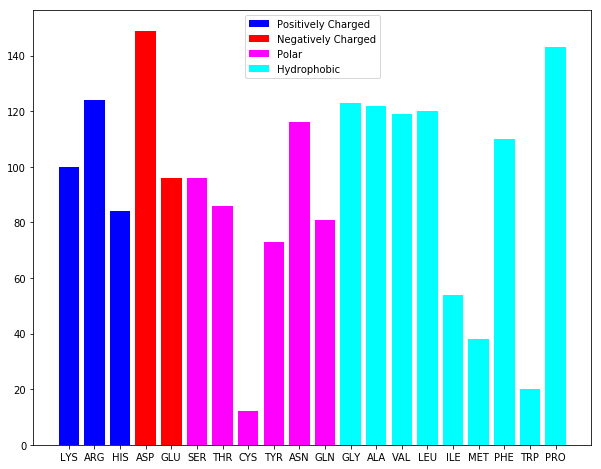

In [111]:
#plotting 
#Change order of residues before making the bar graph
# (!) Positively charged
# (2) Negatively charged
# (3) Polar residues 
# (4) Hydrophobic residues 
x = np.arange(20)
leg = ['Positively Charged', 'Negatively Charged', 'Polar', 'Hydrophobic']
plt.figure(figsize=(10,8))
plt.bar(x[0:3], aa_count['No_of_surf_res (MDAnalysis)'][0:3], color='blue')
plt.bar(x[3:5], aa_count['No_of_surf_res (MDAnalysis)'][3:5], color='red')
plt.bar(x[5:11], aa_count['No_of_surf_res (MDAnalysis)'][5:11], color='magenta')
plt.bar(x[11:20], aa_count['No_of_surf_res (MDAnalysis)'][11:20], color='cyan')
plt.xticks(x,aa_count['Amino_acids'])
plt.legend(leg)

In [113]:
# Number of positively charged residues 
aa_count['No_of_surf_res (MDAnalysis)'][0:3].sum()

308

In [114]:
# Number of negatively charged residues
aa_count['No_of_surf_res (MDAnalysis)'][3:5].sum()

245

In [115]:
# Number of polar residues 
aa_count['No_of_surf_res (MDAnalysis)'][5:11].sum()

464

In [116]:
# Number of hydrophobic residues 
aa_count['No_of_surf_res (MDAnalysis)'][11:20].sum()

849